# Booking model

## Импорт библиотек и подгрузка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import Image, display
import seaborn as sns

from sklearn import preprocessing
# Загружаем encoder
import category_encoders as ce

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели

# Импортируем Comet
import comet_ml

import io
import sys

In [2]:
experiment = comet_ml.start(
   project_name='Booking_model'
)
print(f"Эксперимент создан: {experiment.get_key()}")
print(f"Рабочее пространство: {experiment.workspace}")
print(f"Проект: {experiment.project_name}")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/deslum/booking-model/b65a10d9987e4d1c92ec8a400278376a



Эксперимент создан: b65a10d9987e4d1c92ec8a400278376a
Рабочее пространство: Deslum
Проект: Booking_model


In [3]:
df_hotel_test = pd.read_csv('data/hotels_test.csv', sep = ',')
df_hotel_train = pd.read_csv('data/hotels_train.csv', sep = ',')
df_submission = pd.read_csv('data/submission.csv', sep=',')

In [4]:
print(f'Размер тестового датасета: {df_hotel_test.shape}')
print(f'Размер тренировочного датасета: {df_hotel_train.shape}')
print(f'Размер итогового датасета: {df_submission.shape}')

experiment.log_parameters({
    "Размер тестового датасета:": f"{df_hotel_test.shape[0]}x{df_hotel_test.shape[1]}",
    "Размер тренировочного датасета:": f"{df_hotel_train.shape[0]}x{df_hotel_train.shape[1]}",
    "Размер итогового датасета:": f"{df_submission.shape[0]}x{df_submission.shape[1]}"
})

Размер тестового датасета: (128935, 16)
Размер тренировочного датасета: (386803, 17)
Размер итогового датасета: (128935, 2)


In [5]:
df_hotel_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


## Очистка данных

In [6]:
dups = df_hotel_train[df_hotel_train.duplicated()].shape[0]
print('В тренировочном датасете {} дубликатов'.format(dups))
df_hotel_train = df_hotel_train.drop_duplicates()
print(df_hotel_train.shape)

experiment.log_parameters({
    "Очищено дубликатов:": dups
})

В тренировочном датасете 307 дубликатов
(386496, 17)


Для подготовки данных для модели объединим тренировочные и тестовые данные с пометкой источника

In [7]:
df_hotel_train['is_test'] = 0
df_hotel_test['is_test'] = 1
df = pd.concat([df_hotel_train, df_hotel_test])
display(df.head(2))
display(df.tail(2))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,is_test
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,0


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,is_test
128933,Corso Concordia 1 Milan City Center 20129 Mila...,159,12/26/2015,9.0,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,20,7,NaN,"[' Leisure trip ', ' Solo traveler ', ' Execut...",586 day,45.468236,9.207380,1
128934,202 rue de Rivoli 1st arr 75001 Paris France,297,12/23/2015,8.0,Saint James Albany Paris Hotel Spa,United Kingdom,rooms were very dated and old fashion,8,2868,No Positive,0,1,NaN,"[' Leisure trip ', ' Couple ', ' Standard Room...",589 day,48.864269,2.330818,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515431 entries, 0 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 10  r

In [9]:
# Объявим функцию буфферизациии для логирования

def buffer_to_log(func):
    def wrapper(*args, **kwargs):
        # Сохраняем текущий stdout (который может быть перенаправлен средой)
        original_stdout = sys.stdout
        buffer = io.StringIO()
        try:
            sys.stdout = buffer
            result = func(*args, **kwargs)
        finally:
            # Восстанавливаем сохранённый stdout
            sys.stdout = original_stdout
        return buffer.getvalue()
    return wrapper

# Сначала получим обёртку, потом вызовем
logged_info = buffer_to_log(df.info)()   
experiment.log_asset_data(logged_info, name= "df_info.txt")

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515431 entries, 0 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 10  r

Пропуски присутствуют в `lat` и `lng`. Будем заполнять по адресу отеля

## Подготовка данных

- строковые данные
- пропущенные значения
- генерация признаков
- преобразование признаков
- отбор признаков

### hotel address

Выделим страну и город

In [10]:
df['country']= df['hotel_address'].apply(lambda x: ' '.join(x.split()[-2:]) if 'Kingdom' in x.split()[ -2:] else x.split()[-1:][0])
df['city'] = df.apply(lambda row: row['hotel_address'].split()[-5] if 'Kingdom' in row['country'] else row['hotel_address'].split()[-2], axis= 1)
summary = df[['country','city']].describe().transpose()
display(summary)

experiment.log_table("hotel_address_features.csv", summary)

,count,unique,top,freq
country,515431,6,United Kingdom,262300
city,515431,6,London,262300


{'web': 'https://www.comet.com/api/asset/download?assetId=7410100479bd4c9989b32f5d422487e7&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=7410100479bd4c9989b32f5d422487e7&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '7410100479bd4c9989b32f5d422487e7'}

{'web': 'https://www.comet.com/api/image/download?imageId=01bfedc576724ca5954e6743cc5e76e9&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=01bfedc576724ca5954e6743cc5e76e9&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': '01bfedc576724ca5954e6743cc5e76e9'}

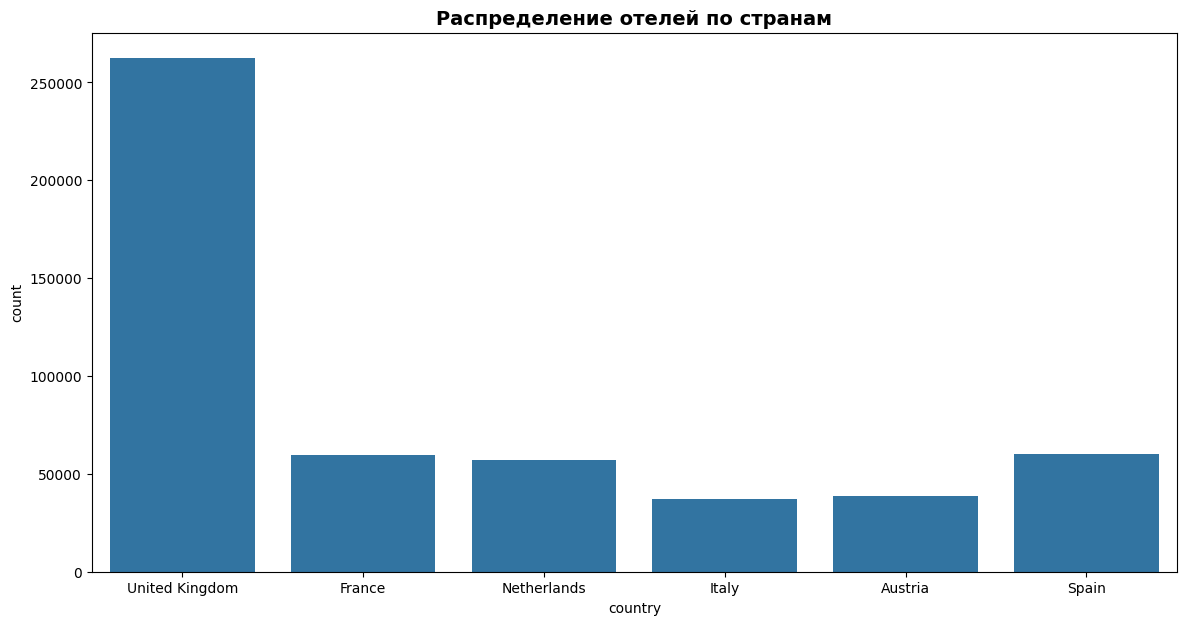

In [11]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.countplot(df, x= 'country', ax = ax)
title_text = 'Распределение отелей по странам'
plt.title(title_text, fontsize = 14, fontweight= 'bold');

experiment.log_figure(figure=fig, figure_name= title_text+'.png')

Из адреса выделил два дополнительных признака `country` и `city`. Заполнив пропуски в `lat` и `lng` найдем еще расстояние отеля до центра города.
Большинство отелей расположено Великобритании

### review_date

In [12]:
# Переводим в формат даты
df['review_date'] = pd.to_datetime(df['review_date'], dayfirst= False)

# добавим признаки Год, Месяц, Квартал, Время года
df['review_year']= df['review_date'].dt.year
df['review_month']= df['review_date'].dt.month
df['review_quarter']= df['review_date'].dt.quarter

seasons = {1: 'winter',
           2: 'spring',
           3: 'summer',
           4: 'autumn'}
df['review_season']= (df['review_date']+pd.DateOffset(months= 1)).dt.quarter.apply(lambda x: seasons[x])

In [13]:
summary = df[['review_season','review_quarter','review_year','review_date','review_month']].describe(include='all').transpose()
display(summary)

experiment.log_table("review_date.csv", summary)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
review_season,515431,4,summer,142800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_quarter,515431.0,NaN,NaN,NaN,2.503282,1.0,2.0,3.0,3.0,4.0,1.088495
review_year,515431.0,NaN,NaN,NaN,2016.120897,2015.0,2016.0,2016.0,2017.0,2017.0,0.687524
review_date,515431,NaN,NaN,NaN,2016-08-13 14:16:05.515849472,2015-08-04 00:00:00,2016-02-23 00:00:00,2016-08-15 00:00:00,2017-02-09 00:00:00,2017-08-03 00:00:00,NaN
review_month,515431.0,NaN,NaN,NaN,6.48623,1.0,4.0,7.0,9.0,12.0,3.35188


{'web': 'https://www.comet.com/api/asset/download?assetId=4566cb8312404f7d81bcf0a447c2a370&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=4566cb8312404f7d81bcf0a447c2a370&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '4566cb8312404f7d81bcf0a447c2a370'}

{'web': 'https://www.comet.com/api/image/download?imageId=7c3e9ac35ba044aaa0e99f24feef0ffd&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=7c3e9ac35ba044aaa0e99f24feef0ffd&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': '7c3e9ac35ba044aaa0e99f24feef0ffd'}

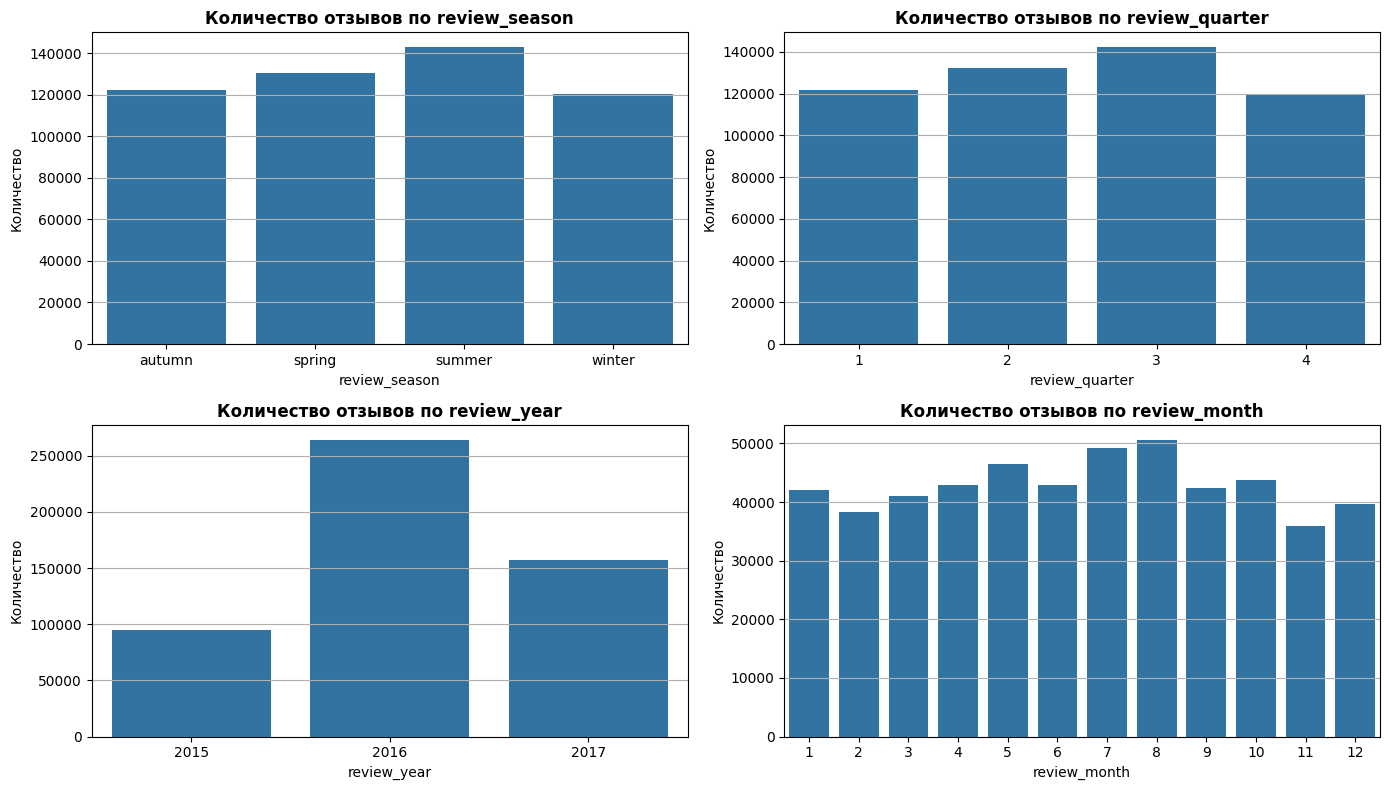

In [14]:
fig, axes = plt.subplots(2,2, figsize= (14, 8))
col_list= ['review_season','review_quarter','review_year','review_month']

for i, col in enumerate(col_list):
    # Номер Axis
    ax= axes[i // 2, i % 2]
    
    sns.barplot(df.groupby(by= col)[col].count(), ax=ax)
    
    # Украшательство
    
    title_text = "Количество отзывов"
    ax.set_title(f"{title_text} по {col}", fontweight= 'bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Количество')
    ax.tick_params(axis='x')
    ax.grid(axis='y')
    
plt.tight_layout()

experiment.log_figure(figure=fig, figure_name= title_text+'.png')

Из данного признака выделили 4 доплительных: сезон, квартал, год и месяц.
Из рапсределения видно, что наибольщее количество отзывов приходится на 2 и 3 кварталы и сезоны. Также большее количество отзывов представлено в 2026 году.

### average_score

,count,mean,std,min,25%,50%,75%,max
average_score,515431.0,8.39763,0.548033,5.2,8.1,8.4,8.8,9.8


{'web': 'https://www.comet.com/api/image/download?imageId=b210a9dc45d144b1acaa628cd7de7194&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=b210a9dc45d144b1acaa628cd7de7194&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': 'b210a9dc45d144b1acaa628cd7de7194'}

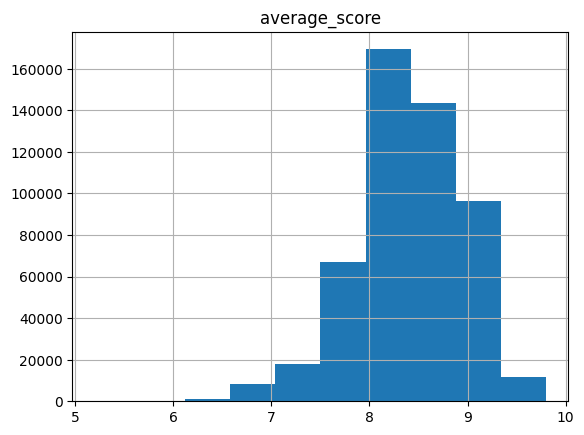

In [15]:
summary= df['average_score'].describe().to_frame().transpose()
display(summary)
experiment.log_table("average_score_hist.csv", summary)

df[['average_score']].hist();

# Получим текущую фигуру для логирования
fig = plt.gcf()               
experiment.log_figure(figure=fig, figure_name="average_score_hist.png")

Средний бал за последний год варьируется от 5.2 до 9.8. Наибольшая плотность представлена в районе 8.4

### hotel_name

In [16]:
summary = df['hotel_name'].describe().to_frame()
display(summary)

experiment.log_table("hotel_names.csv", summary)

,hotel_name
count,515431
unique,1492
top,Britannia International Hotel Canary Wharf
freq,4789


{'web': 'https://www.comet.com/api/asset/download?assetId=51c417bdd6cc4de6a8ca4a1b54c30578&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=51c417bdd6cc4de6a8ca4a1b54c30578&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '51c417bdd6cc4de6a8ca4a1b54c30578'}

В данных присутствует 1492 уникальных значения отеля

### reviewer_nationality

,count,unique,top,freq
reviewer_nationality,515431,227,United Kingdom,245165


{'web': 'https://www.comet.com/api/image/download?imageId=25dce3933ff84aadbf4f2490738a2f9f&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=25dce3933ff84aadbf4f2490738a2f9f&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': '25dce3933ff84aadbf4f2490738a2f9f'}

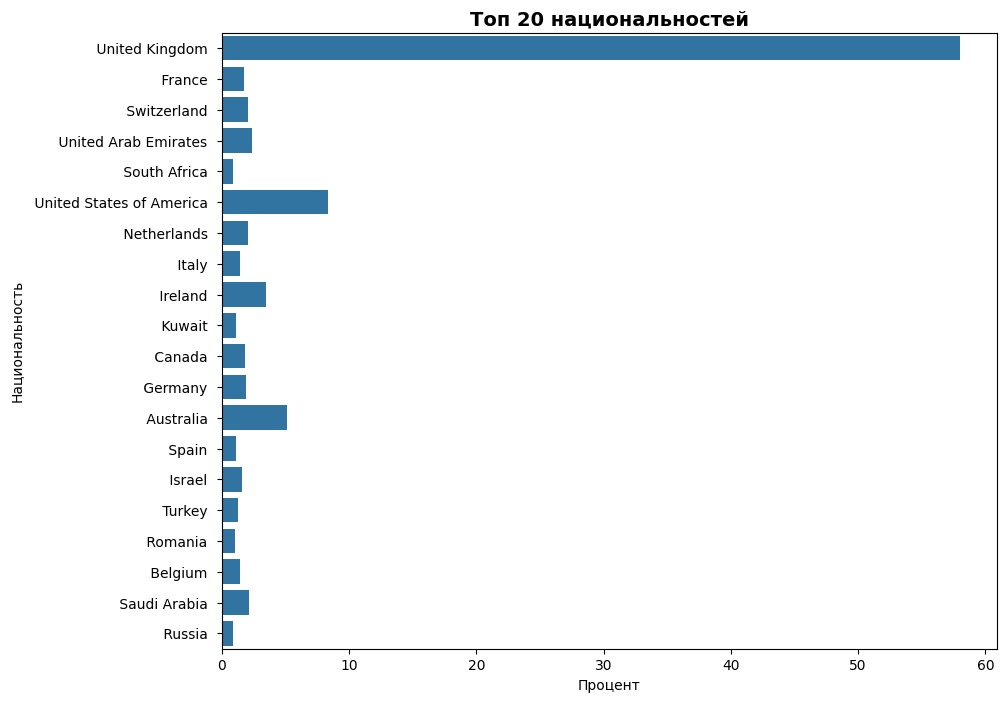

In [17]:
summary = df['reviewer_nationality'].describe().to_frame().transpose()
display(summary)

experiment.log_table("reviewer_nationality.csv", summary)

# Получим топ 20 национальностей
top_nations= df['reviewer_nationality'].value_counts(ascending=False).head(20)
top_nations= top_nations.keys().to_list()
k = df[df['reviewer_nationality'].isin(top_nations)]

# Отрисуем график с процентным соотношением национальностей
fig, ax = plt.subplots(figsize=(10, 8))

sns.countplot(k, y= 'reviewer_nationality', stat='percent', ax= ax)

text_title = 'Топ 20 национальностей'
plt.title(text_title, fontsize = 14, fontweight= 'bold')
plt.ylabel('Национальность')
plt.xlabel('Процент');

experiment.log_figure(figure=fig, figure_name=text_title+'.png')

В признаке 227 уникальных значений. В дальнейшем будем кодировать бинарным кодированием

### negative_review

In [18]:
display(df['negative_review'].describe().to_frame().transpose())
df['review_is_negative'] = df['negative_review'].apply(lambda x: 0 if x.lower().strip() in ['no negative','none', '', 'nothing', 'n a'] else 1)
summary= df[df['review_is_negative']==1]['negative_review'].describe().to_frame().transpose()
display(summary)

experiment.log_table("negative_review.csv", summary)

,count,unique,top,freq
negative_review,515431,330011,No Negative,127816


,count,unique,top,freq
negative_review,362273,329988,Breakfast,407


{'web': 'https://www.comet.com/api/asset/download?assetId=10418a50e3ef4be787f0758c16147abd&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=10418a50e3ef4be787f0758c16147abd&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '10418a50e3ef4be787f0758c16147abd'}

С учетом наличия в отзывах неинформативной информации 'no negative','none', 'nothing', 'n a' создали новый признак `review_is_negative`. Количество настоящих негативных отзывов резко уменьшилось, что повлияет на работу модели

### review_total_negative_word_counts

In [19]:
summary = df['review_total_negative_word_counts'].describe().to_frame().transpose()
display(summary)

experiment.log_table("review_total_negative_word_counts.csv", summary)

,count,mean,std,min,25%,50%,75%,max
review_total_negative_word_counts,515431.0,18.53976,29.690973,0.0,2.0,9.0,23.0,408.0


{'web': 'https://www.comet.com/api/asset/download?assetId=78350bc29f164091985a3698c75e0962&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=78350bc29f164091985a3698c75e0962&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '78350bc29f164091985a3698c75e0962'}

Распределение количества слов в негативных отзывах содержит много выбросов, о чем говорит большая разница между средним и медианным значениями

COMET INFO: Trying to log a figure that is exceeding allowed SVG file size limit (2838513 > 1048576). Falling back to PNG format.


{'web': 'https://www.comet.com/api/image/download?imageId=74ca99e812904ecf897ec61ee4d10b59&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=74ca99e812904ecf897ec61ee4d10b59&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': '74ca99e812904ecf897ec61ee4d10b59'}

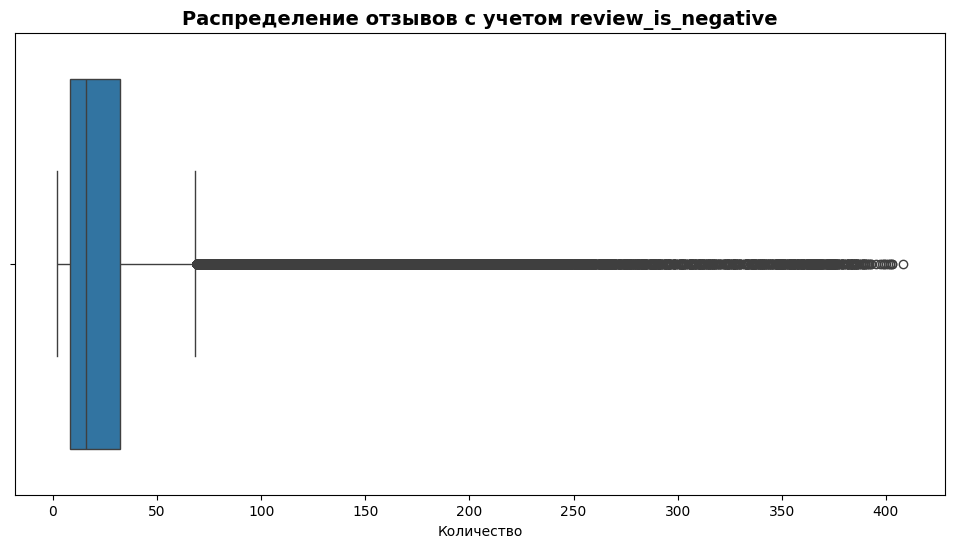

In [20]:
# Посмотрим на распредение слов с учетом настоящих негативных отзывов
fig, ax= plt.subplots(figsize= (12,6))
sns.boxplot(df[df['review_is_negative']==1],
            x= 'review_total_negative_word_counts', ax=ax)

title_text = "Распределение отзывов с учетом review_is_negative"
plt.title(title_text, fontsize = 14, fontweight= 'bold')
plt.xlabel('Количество');

experiment.log_figure(figure=fig, figure_name=title_text+'.png')

### total_number_of_reviews

In [21]:
summary= df['total_number_of_reviews'].describe().to_frame().transpose()
display(summary)

experiment.log_table("total_number_of_reviews.csv", summary)

,count,mean,std,min,25%,50%,75%,max
total_number_of_reviews,515431.0,2744.259084,2317.823718,43.0,1161.0,2134.0,3633.0,16670.0


{'web': 'https://www.comet.com/api/asset/download?assetId=63d347471859429fa2fcc74ff64bf5e4&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=63d347471859429fa2fcc74ff64bf5e4&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '63d347471859429fa2fcc74ff64bf5e4'}

### positive_review

In [22]:
display(df['positive_review'].describe().to_frame().transpose())
df['review_is_positive']= df['positive_review'].apply(lambda x: 0 if x.lower().strip() in ['no positive', 'nothing', ''] else 1)
summary= df[df['review_is_positive']==1 ]['positive_review'].describe().to_frame().transpose()

display(summary)

experiment.log_table("positive_review.csv", summary)

,count,unique,top,freq
positive_review,515431,412601,No Positive,35924


,count,unique,top,freq
positive_review,477595,412593,Location,9213


{'web': 'https://www.comet.com/api/asset/download?assetId=48258e639a0f4d59bdd2cb12c6436458&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=48258e639a0f4d59bdd2cb12c6436458&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '48258e639a0f4d59bdd2cb12c6436458'}

С учетом наличия в отзывах неинформативной информации 'no positive', 'nothing', создали новый признак `review_is_positive`. Количество настоящих позитивных отзывов резко уменьшилось, что повлияет на работу модели

### review_total_positive_word_counts

In [23]:
summary= df['review_total_positive_word_counts'].describe().to_frame().transpose()
display(summary)

experiment.log_table("review_total_positive_word_counts.csv", summary)

,count,mean,std,min,25%,50%,75%,max
review_total_positive_word_counts,515431.0,17.777342,21.803204,0.0,5.0,11.0,22.0,395.0


{'web': 'https://www.comet.com/api/asset/download?assetId=df5a4ad595c7405885f032e98b36af46&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=df5a4ad595c7405885f032e98b36af46&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': 'df5a4ad595c7405885f032e98b36af46'}

Распределение количества слов в позитивных отзывах содержит много выбросов, о чем говорит большая разница между средним и медианным значениями

COMET INFO: Trying to log a figure that is exceeding allowed SVG file size limit (3366613 > 1048576). Falling back to PNG format.


{'web': 'https://www.comet.com/api/image/download?imageId=26edf8f0116b4e76879cc0268aa569a2&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=26edf8f0116b4e76879cc0268aa569a2&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': '26edf8f0116b4e76879cc0268aa569a2'}

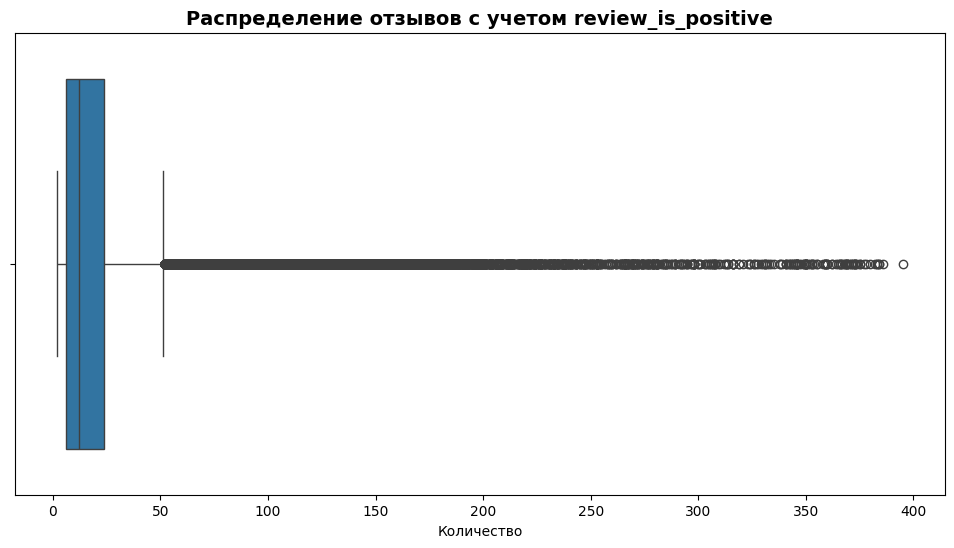

In [24]:
# Посмотрим на распредение слов с учетом настоящих позитивных отзывов
fig, ax= plt.subplots(figsize= (12,6))
sns.boxplot(df[df['review_is_positive']==1],
            x= 'review_total_positive_word_counts', ax=ax)
title_text= 'Распределение отзывов с учетом review_is_positive'
plt.title(title_text, fontsize = 14, fontweight= 'bold')
plt.xlabel('Количество');

experiment.log_figure(figure=fig, figure_name=title_text+'.png')

### total_number_of_reviews_reviewer_has_given

In [25]:
summary= df['total_number_of_reviews_reviewer_has_given'].describe().to_frame().transpose()
display(summary)

experiment.log_table("total_number_of_reviews_reviewer_has_given.csv", summary)

,count,mean,std,min,25%,50%,75%,max
total_number_of_reviews_reviewer_has_given,515431.0,7.165215,11.038742,1.0,1.0,3.0,8.0,355.0


{'web': 'https://www.comet.com/api/asset/download?assetId=888d29e0cae54081a101e6aaab5729c1&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=888d29e0cae54081a101e6aaab5729c1&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '888d29e0cae54081a101e6aaab5729c1'}

### tags

In [26]:
df['tags'].describe().to_frame().transpose()

,count,unique,top,freq
tags,515431,55242,"[' Leisure trip ', ' Couple ', ' Double Room '...",5101


In [27]:
# Преобразуем строку `tags` в список
df['tags'] = df['tags'].apply(lambda x: x.strip("[] '").split(" ', ' "))

In [28]:
# Создадим список уникальных значений tag
tag_list = []
for tag in df['tags']:
    for item in tag:
        if item not in tag_list:
            tag_list.append(item)

In [29]:
print(f'В данных представлено {len(tag_list)} уникальных тегов')

В данных представлено 2428 уникальных тегов


Среди указанных тегов выделим: 
- `тип поездки`, 
- `возможность взять питомца`, 
- `тип заселения/аппартаментов`, 
- `тип постояльцев`, 
- `количество проведенных ночей`, 
- `отзыв оставлен с мобильного телефона`.

In [30]:
# Функция создания новых признаков на основании тегов
# Принимает в себя список тегов и значение конкретного признака
# Возвращает значение признака, если встречается указанный тег
def add_feature(feature, list_t, lower_f = True):
    result = 'Uknown'
    for element in feature:
        for item in list_t:
            if lower_f:
                if item in element.lower():
                    result =  element
            else:
                if item in element:
                    result =  element
    return result

**Тип поездки**

In [31]:
# Список тегов
trip_t = ['trip']

#Список признаков по тегу (требуется для итоговой проверки неучтенных тегов)
trip_type = list(filter(lambda x: any(t in x for t in trip_t), tag_list))
print(trip_type)

['Leisure trip', 'Business trip']


{'web': 'https://www.comet.com/api/image/download?imageId=217a58967968468e965e3c1180acfb5b&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=217a58967968468e965e3c1180acfb5b&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': '217a58967968468e965e3c1180acfb5b'}

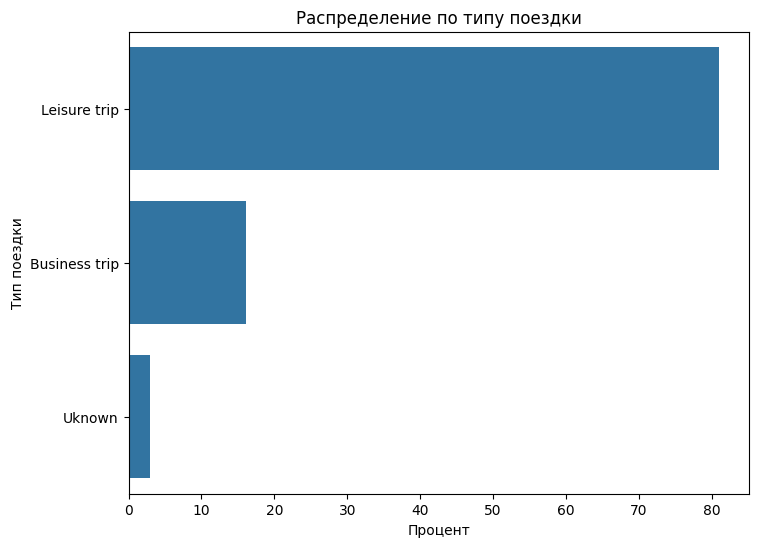

In [32]:
# используем созданную функцию для создания нового признака
df['trip_type'] = df['tags'].apply(lambda x: add_feature(x, trip_t, False))

fig, ax= plt.subplots(figsize= (8,6))
sns.countplot(df['trip_type'], stat='percent', ax=ax)

title_text= 'Распределение по типу поездки'
plt.title(title_text)
plt.xlabel('Процент')
plt.ylabel('Тип поездки');
experiment.log_figure(figure= fig, figure_name= title_text+'.png')

**Тип заселения**

In [33]:
# Список тегов
room_t = ['room', 'suite', 'apartment', 'deluxe', 'apartement', 'atrium', 
          'double', 'king', 'queen', 'designer', 'studio', 'garden', 'superior',
          'twin', 'corner', 'duplex', 'special', 'square', 'view', 'bank',
          'cosy', 'plan', 'maison', 'loft', 'penthouse', 'club', 'nest','luxury', 
          'premium', 'terrace', 'standard']

# Список признаков по тегу (требуется для итоговой проверки неучтенных тегов)
room_type = list(filter(lambda x: any(t in x.lower() for t in room_t), tag_list))
len(room_type)

2387

In [34]:
df['room_type'] = df['tags'].apply(lambda x: add_feature(x, room_t))
print('Количество уникальных значений с типом комнат: {}'.format(df['room_type'].nunique()))

Количество уникальных значений с типом комнат: 2388


Посмотрим на топ 10 типов комнат

{'web': 'https://www.comet.com/api/image/download?imageId=6debe2c01c9e4611b104e442c7c17ee6&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=6debe2c01c9e4611b104e442c7c17ee6&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': '6debe2c01c9e4611b104e442c7c17ee6'}

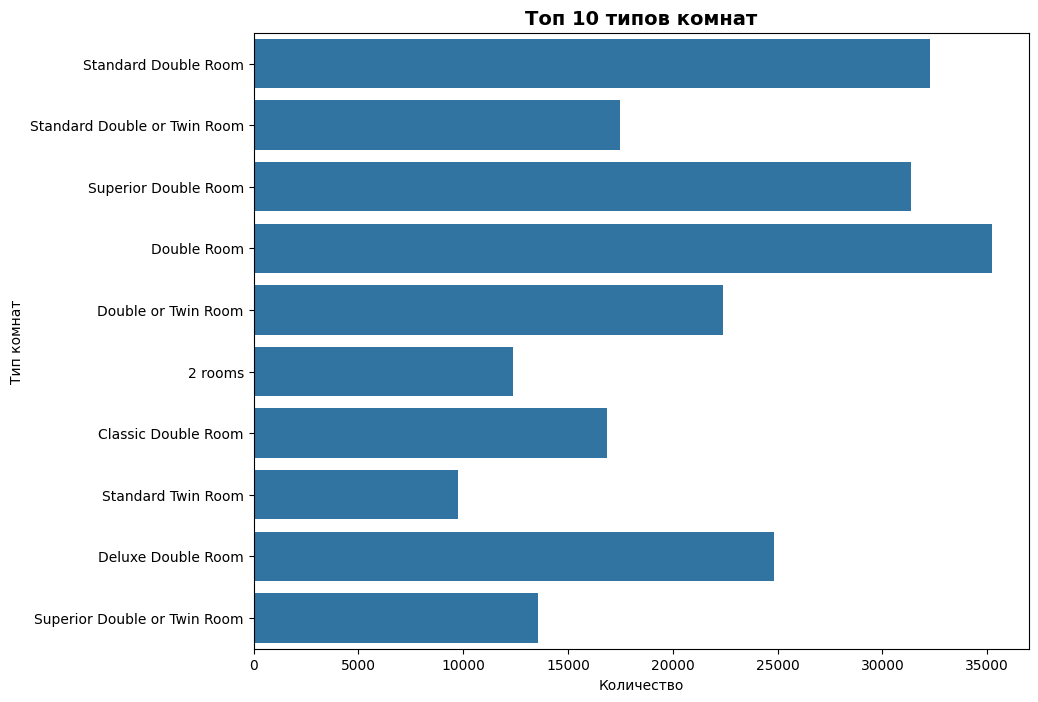

In [35]:
top_room = df['room_type'].value_counts(ascending=False).head(10)
top_rooms= top_room.keys().to_list()
k = df[df['room_type'].isin(top_rooms)]

# Отрисуем график с процентным соотношением национальностей
fig, ax = plt.subplots(figsize=(10, 8))

sns.countplot(k, y= 'room_type', stat='count', ax= ax)

text_title= 'Топ 10 типов комнат'
plt.title(text_title, fontsize = 14, fontweight= 'bold')
plt.ylabel('Тип комнат')
plt.xlabel('Количество');

experiment.log_figure(figure= fig, figure_name= text_title+'.png')

Наибольшим спросом пользуются двухкомнатные аппартаменты\
Для улучшения работы модели типы комнат, возможно, придется стандартизировать  

**Количество ночей**

In [36]:
# Список тегов
nights_s = ['stayed']

# Список признаков по тегу (требуется для итоговой проверки неучтенных тегов)
nights_stayed = list(filter(lambda x: any(t in x.lower() for t in nights_s), tag_list))
len(nights_stayed)

31

,count,mean,std,min,25%,50%,75%,max
nights_count,515431.0,2.361129,1.647346,0.0,1.0,2.0,3.0,31.0


COMET INFO: Trying to log a figure that is exceeding allowed SVG file size limit (1512709 > 1048576). Falling back to PNG format.


{'web': 'https://www.comet.com/api/image/download?imageId=7de9beb413414ba6a05bf6bbd1460e38&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=7de9beb413414ba6a05bf6bbd1460e38&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': '7de9beb413414ba6a05bf6bbd1460e38'}

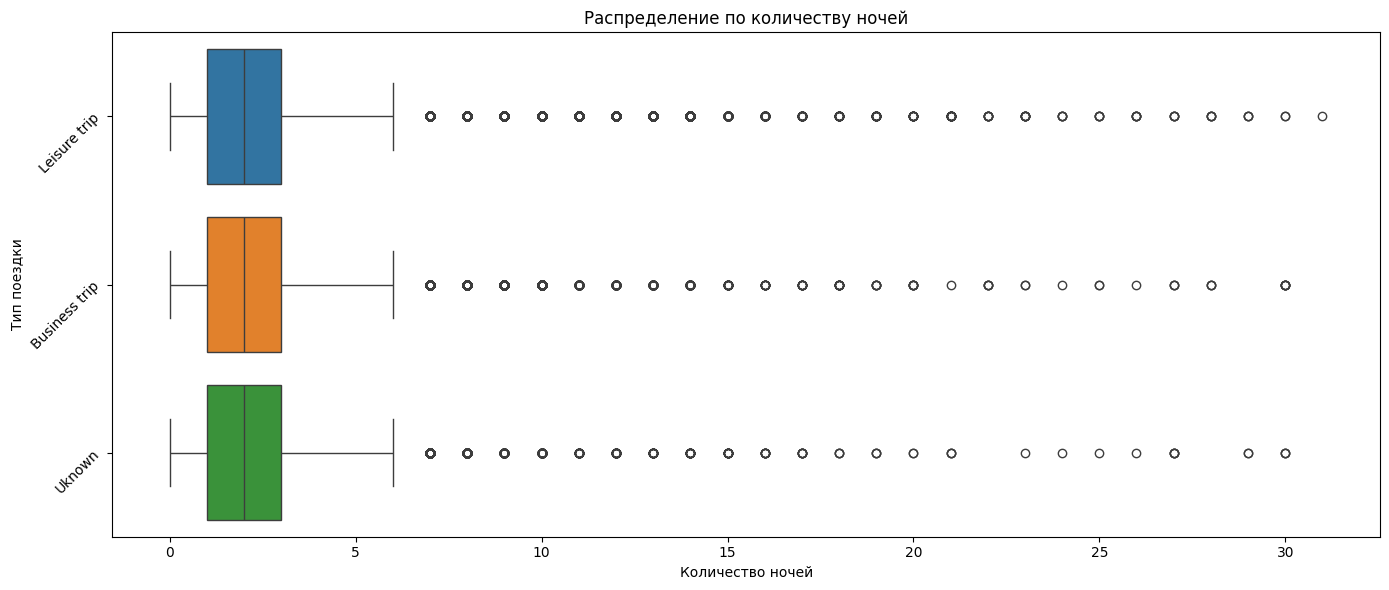

In [37]:
df['nights_count'] = df['tags'].apply(lambda x: add_feature(x, nights_s))

# Выделим количество ночей
df['nights_count'] = df['nights_count'].apply(lambda x: x.split(' ')[1] if len(x.split(' '))>1 else 0).astype('int32')

summary= df['nights_count'].describe().to_frame().transpose()
display(summary)

experiment.log_table("Количество ночей.csv", summary)

fig, ax= plt.subplots(figsize= (14,6))
sns.boxplot(df, x='nights_count', y='trip_type', hue= 'trip_type', ax= ax)

text_title = 'Распределение по количеству ночей'
plt.title(text_title)
plt.xlabel('Количество ночей')
plt.ylabel('Тип поездки')
plt.yticks(rotation= 45)
plt.tight_layout();

experiment.log_figure(figure= fig, figure_name= text_title+'.png')

В большинстве случаев в отелях останавливаются на пару ночей независимо от типа поездки

**Тип путешественника**

In [38]:
# Список тегов
voyager_t = ['couple', 'group', 'traveler', 'family with']

# Список признаков по тегу (требуется для итоговой проверки неучтенных тегов)
voyager_type = list(filter(lambda x: any(t in x.lower() for t in voyager_t), tag_list))
voyager_type

['Couple',
 'Solo traveler',
 'Family with young children',
 'Group',
 'Family with older children',
 'Travelers with friends']

{'web': 'https://www.comet.com/api/image/download?imageId=c7b5f1ca854942a0ad69702158ab03b1&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=c7b5f1ca854942a0ad69702158ab03b1&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': 'c7b5f1ca854942a0ad69702158ab03b1'}

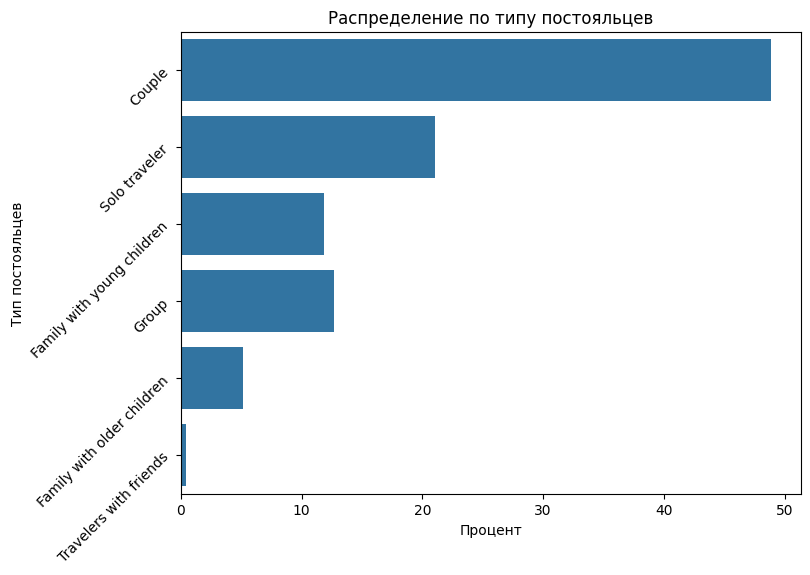

In [39]:
df['voyager_type'] = df['tags'].apply(lambda x: add_feature(x, voyager_t))
fig, ax= plt.subplots(figsize= (8,6))
sns.countplot(df['voyager_type'], stat='percent', ax= ax)

text_title= 'Распределение по типу постояльцев'
plt.title(text_title)
plt.xlabel('Процент')
plt.ylabel('Тип постояльцев')
plt.yticks(rotation= 45);

experiment.log_figure(figure= fig, figure_name= text_title+'.png')

Чаще всего в номерах останавливаются пары (`couple`) 

**Индикатор отдыха с животным**

In [40]:
# Список тегов
pet_t = ['with a pet']

# Список признаков по тегу (требуется для итоговой проверки неучтенных тегов)
pet_type = list(filter(lambda x: any(t in x.lower() for t in pet_t), tag_list))
pet_type

['With a pet']

In [41]:
df['with_a_pet'] = df['tags'].apply(lambda x: add_feature(x, pet_t))
df['with_a_pet'] = df['with_a_pet'].apply(lambda x: 0 if x == 'Uknown' else 1)
df['with_a_pet'].value_counts().to_frame().reset_index()

,with_a_pet,count
0,0,514026
1,1,1405


Количество отдыхающих с животными крайне мало по сравнению с общим числом постояльцев

**Индикатор отправки отзыва с мобильного телефона**

In [42]:
# Список тегов
mobile_device_t = ['submitted']

# Список признаков по тегу (требуется для итоговой проверки неучтенных тегов)
mobile_device_type = list(filter(lambda x: any(t in x.lower() for t in mobile_device_t), tag_list))
mobile_device_type

['Submitted from a mobile device']

In [43]:
df['mobile_submitted'] = df['tags'].apply(lambda x: add_feature(x, mobile_device_t))
df['mobile_submitted'] = df['mobile_submitted'].apply(lambda x: 0 if x == 'Uknown' else 1)
summary= df['mobile_submitted'].value_counts().to_frame().reset_index()
display(summary)

experiment.log_table("mobile_submitted.csv", summary)

,mobile_submitted,count
0,1,307470
1,0,207961


{'web': 'https://www.comet.com/api/asset/download?assetId=2b189f811b8a486f9bcd94ce2dba79b2&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=2b189f811b8a486f9bcd94ce2dba79b2&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '2b189f811b8a486f9bcd94ce2dba79b2'}

Большинство отзывов направлено с мобильного телефона

**Проверка неучтенных тегов**

In [44]:
s = set(tag_list)-set(room_type)-set(trip_type)-set(nights_stayed)-set(voyager_type)-set(pet_type)-set(mobile_device_type)
print(f'Количество неучтенных тегов: {len(s)}')
if len(s) > 0:
    s

Количество неучтенных тегов: 0


### days_since_review

In [45]:
df['days_since_review'] = df['days_since_review'].apply(lambda x: x.split(' ')[0]).astype('int')

In [46]:
summary= df['days_since_review'].describe().to_frame().transpose()
display(summary)

experiment.log_table("Days_since_review.csv", summary)

,count,mean,std,min,25%,50%,75%,max
days_since_review,515431.0,354.405492,208.915335,0.0,175.0,353.0,527.0,730.0


{'web': 'https://www.comet.com/api/asset/download?assetId=37dabeea18ef4e9bbe707a32bcaf5c66&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=37dabeea18ef4e9bbe707a32bcaf5c66&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '37dabeea18ef4e9bbe707a32bcaf5c66'}

{'web': 'https://www.comet.com/api/image/download?imageId=b1fc45dd17b348339c698dc8220f4cb7&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=b1fc45dd17b348339c698dc8220f4cb7&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': 'b1fc45dd17b348339c698dc8220f4cb7'}

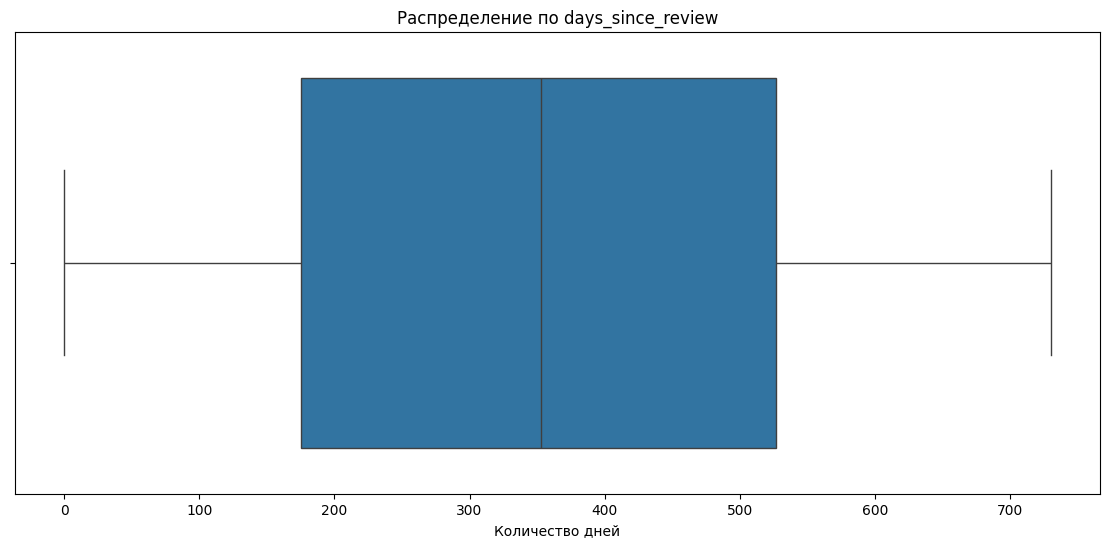

In [47]:
fig, ax= plt.subplots(figsize= (14,6))
sns.boxplot(df, x='days_since_review', ax= ax)

text_title= "Распределение по days_since_review"
plt.title(text_title)
plt.xlabel('Количество дней');

experiment.log_figure(figure= fig, figure_name= text_title+'.png')

### additional_number_of_scoring

In [48]:
summary= df['additional_number_of_scoring'].describe().to_frame().transpose()
display(summary)

experiment.log_table("additional_number_of_scoring.csv", summary)

,count,mean,std,min,25%,50%,75%,max
additional_number_of_scoring,515431.0,498.275079,500.618961,1.0,169.0,342.0,660.0,2682.0


{'web': 'https://www.comet.com/api/asset/download?assetId=1417bd1feb284153be58753e01889ebb&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=1417bd1feb284153be58753e01889ebb&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '1417bd1feb284153be58753e01889ebb'}

COMET INFO: Trying to log a figure that is exceeding allowed SVG file size limit (3159955 > 1048576). Falling back to PNG format.


{'web': 'https://www.comet.com/api/image/download?imageId=a609f2b63e814376a7394255cf8ff625&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=a609f2b63e814376a7394255cf8ff625&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': 'a609f2b63e814376a7394255cf8ff625'}

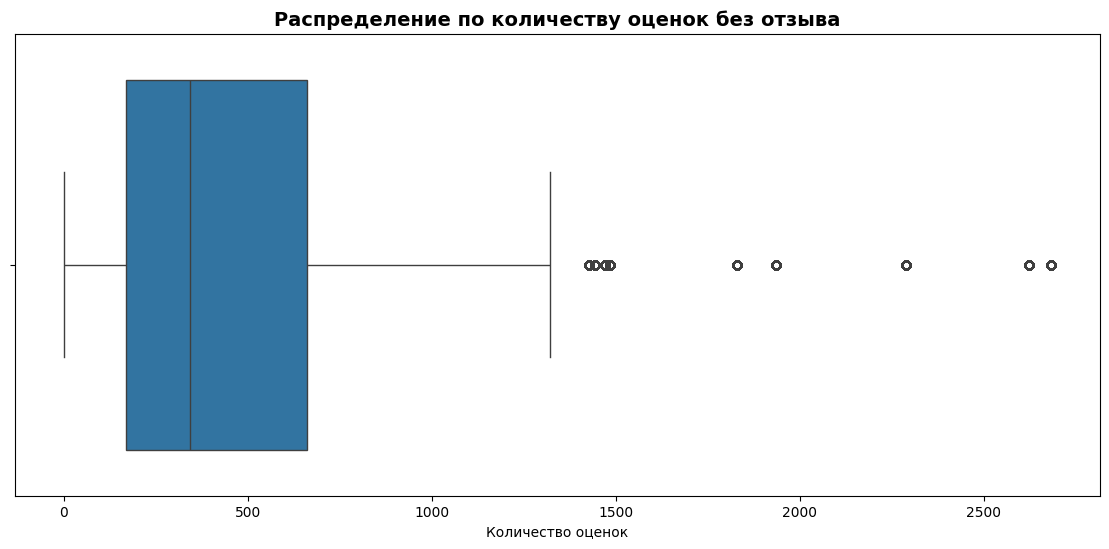

In [49]:
fig, ax= plt.subplots(figsize= (14,6))
sns.boxplot(df, x='additional_number_of_scoring', ax= ax)

text_title= 'Распределение по количеству оценок без отзыва'
plt.title(text_title, fontsize = 14, fontweight = 'bold')
plt.xlabel('Количество оценок');

experiment.log_figure(figure= fig, figure_name= text_title+'.png')

### lat и lng

In [50]:
print('Количество пропущенных значений в признаке lat: {}'.format(df[df['lat'].isna()].shape[0]))
print('Количество пропущенных значений в признаке lng: {}'.format(df[df['lng'].isna()].shape[0]))

Количество пропущенных значений в признаке lat: 3268
Количество пропущенных значений в признаке lng: 3268


In [51]:
#Определим перечень адресов отелей с пропусками
null_address= df[(df['lat'].isna())|(df['lng'].isna())]['hotel_address'].unique().tolist()
display(null_address)
print(df[(df['lat'].isna())|(df['lng'].isna())]['country'].unique())
print(df[(df['lat'].isna())|(df['lng'].isna())]['city'].unique())

['Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
 '23 Rue Damr mont 18th arr 75018 Paris France',
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
 '4 rue de la P pini re 8th arr 75008 Paris France',
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
 'Bail n 4 6 Eixample 08010 Barcelona Spain',
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
 '20 Rue De La Ga t 14th arr 75014 Paris France',
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
 'Sep lveda 180 Eixample 08011 Barcelona Spain',
 'Pau Clar s 122 Eixample 08009 Barcelona Spain',
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria']

['Austria' 'France' 'Spain']
['Vienna' 'Paris' 'Barcelona']


In [52]:
#В ручную найдем параметры для 17 адресов:
raw_addresses = {
    "20 Rue De La Ga t 14th arr 75014 Paris France": (48.839996, 2.307082),
    "23 Rue Damr mont 18th arr 75018 Paris France": (48.888913, 2.330964),
    "4 rue de la P pini re 8th arr 75008 Paris France": (48.875321, 2.321203),
    "Bail n 4 6 Eixample 08010 Barcelona Spain": (41.391552, 2.175705),
    "Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria": (48.220855, 16.364423),
    "Hasenauerstra e 12 19 D bling 1190 Vienna Austria": (48.233592, 16.343478),
    "Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria": (48.209405, 16.351257),
    "Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria": (48.209553, 16.349275),
    "Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria": (48.188818, 16.381591),
    "Paragonstra e 1 11 Simmering 1110 Vienna Austria": (48.186814, 16.418528),
    "Pau Clar s 122 Eixample 08009 Barcelona Spain": (41.374995, 2.110235),
    "Savoyenstra e 2 16 Ottakring 1160 Vienna Austria": (48.219573, 16.283403),
    "Sep lveda 180 Eixample 08011 Barcelona Spain": (41.383243, 2.160761),
    "Sieveringer Stra e 4 19 D bling 1190 Vienna Austria": (48.245891, 16.339740),
    "Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria": (48.213591, 16.377720),
    "W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria": (48.216803, 16.357717),
    "W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria": (48.220414, 16.353630)
}
# Создадим временную таблицу с адресами
geo_df = pd.DataFrame(raw_addresses.values(), index=raw_addresses.keys(), columns= ['lat', 'lng'])
geo_df

,lat,lng
20 Rue De La Ga t 14th arr 75014 Paris France,48.839996,2.307082
23 Rue Damr mont 18th arr 75018 Paris France,48.888913,2.330964
4 rue de la P pini re 8th arr 75008 Paris France,48.875321,2.321203
Bail n 4 6 Eixample 08010 Barcelona Spain,41.391552,2.175705
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,48.220855,16.364423
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,48.233592,16.343478
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,48.209405,16.351257
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,48.209553,16.349275
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,48.188818,16.381591
Paragonstra e 1 11 Simmering 1110 Vienna Austria,48.186814,16.418528


In [53]:
df = df.set_index('hotel_address')  #установим индекс по адресу отеля
df.update(geo_df)                   #обновим значения долготы и широты по временному справочнику
df= df.reset_index()                #обнулим индексы
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

In [54]:
# Для нахождения расстояний нам поможет pyproj
from pyproj import Geod
GEOD = Geod(ellps="WGS84")

In [55]:
# Определим списки центров
city_center = {
    "London": (51.5074, -0.1278),
    "Paris": (48.8566, 2.3522),
    "Amsterdam": (52.3676, 4.9041),
    "Milan": (45.4642, 9.19),
    "Vienna": (48.2082, 16.3738),
    "Barcelona": (41.3851, 2.1734),
}

#Определим функцию нахождения долготы и широты из датасета и справочника центров
def dist_row(row):
            city = row["city"]
            lat0, lon0 = city_center[city]
            lat1, lon1 = row["lat"], row["lng"]
            _, _, dist = GEOD.inv(lon0, lat0, lon1, lat1)
            return dist / 1_000  # km

df['distance_to_center'] = df.apply(lambda row: dist_row(row), axis=1)

In [56]:
summary= df['distance_to_center'].describe().to_frame().transpose()
display(summary)

experiment.log_table("Расстояние до центра.csv", summary)

,count,mean,std,min,25%,50%,75%,max
distance_to_center,515431.0,3.156224,2.555996,0.075371,1.372014,2.471418,4.088286,17.189438


{'web': 'https://www.comet.com/api/asset/download?assetId=86fd86d0bc904f4baafd1e9c1be029aa&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=86fd86d0bc904f4baafd1e9c1be029aa&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '86fd86d0bc904f4baafd1e9c1be029aa'}

В итоге заполнили пропуски в `lat` и `lng`. Используя полученные данные сформировали новый признак расстояния до центра города.\
Из полученных данных видим, что медианное значение равно 2,5 км, а самый отдаленный отель на расстоянии 17 км

## Преобразование данных

Оценим наши признаки на необходимость преобразования данных

In [57]:
obj_columns = [c for c in df.columns if df[c].dtype =="object"]
display(obj_columns)

['hotel_address',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'country',
 'city',
 'review_season',
 'trip_type',
 'room_type',
 'voyager_type']

Из представленных признаков нас интересуют несколько:

In [58]:
list_to_code = ['reviewer_nationality', 'country', 'city', 'review_season', 'trip_type', 'voyager_type']
summary= df[list_to_code].describe(include= 'all')
display(summary)

experiment.log_table("Инфо о кодируемых признаках.csv", summary)

,reviewer_nationality,country,city,review_season,trip_type,voyager_type
count,515431,515431,515431,515431,515431,515431
unique,227,6,6,4,3,6
top,United Kingdom,United Kingdom,London,summer,Leisure trip,Couple
freq,245165,262300,262300,142800,417538,252128


{'web': 'https://www.comet.com/api/asset/download?assetId=1e2dcf6b4cb148f3ac99958e85dde498&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=1e2dcf6b4cb148f3ac99958e85dde498&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '1e2dcf6b4cb148f3ac99958e85dde498'}

Признак `reviewer_nationality` будем кодировать бинарным методом, остальные однократным кодированием.
Ввиду большой корреляции города и страны уберем из кодирования город

In [59]:
one_hot_list = ['country', 'review_season', 'trip_type', 'voyager_type']
encoder = ce.OneHotEncoder(cols=one_hot_list, use_cat_names= True)
one_hot_bin = encoder.fit_transform(df[one_hot_list])
df = pd.concat([df, one_hot_bin], axis=1)
display(df.head())

experiment.log_table("one_hot_sample.csv", one_hot_bin.head(20))
experiment.log_asset_data(f"Добавлено признаков: {one_hot_bin.shape[1]}", name="one_hot_info.txt")
experiment.log_table("df_head.csv", df.head(10))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,review_season_summer,trip_type_Leisure trip,trip_type_Business trip,trip_type_Uknown,voyager_type_Couple,voyager_type_Solo traveler,voyager_type_Family with young children,voyager_type_Group,voyager_type_Family with older children,voyager_type_Travelers with friends
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,0,1,0,0,1,0,0,0,0,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,0,1,0,1,0,0,0,0,0
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,0,1,0,0,0,1,0,0,0,0
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,0,1,0,0,0,1,0,0,0,0
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,0,0,1,0,1,0,0,0,0,0


{'web': 'https://www.comet.com/api/asset/download?assetId=81b2436233fd48079ac39ebba4526408&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=81b2436233fd48079ac39ebba4526408&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '81b2436233fd48079ac39ebba4526408'}

Однократным кодированием получили 19 новых признаков.\
Закодируем `reviewer_nationality`

In [60]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(df['reviewer_nationality'])
df = pd.concat([df, type_bin], axis=1)
display(df.head())

experiment.log_table("binary_sample.csv", type_bin.head(20))
experiment.log_asset_data(f"Добавлено признаков: {type_bin.shape[1]}", name="binary_info.txt")
experiment.log_table("df_head.csv", df.head(10))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,voyager_type_Family with older children,voyager_type_Travelers with friends,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,0,0,0,0,0,0,0,0,0,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,0,0,0,0,0,0,0,0,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,0,0,0,0,0,0,0,0,1,0
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,0,0,0,0,0,0,0,0,0,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,0,0,0,0,0,0,0,0,1,1


{'web': 'https://www.comet.com/api/asset/download?assetId=761c34699e8a426b9e266d19607c39dd&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=761c34699e8a426b9e266d19607c39dd&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': '761c34699e8a426b9e266d19607c39dd'}

В таблицу добавлено 8 новых признаков\
Удалим столбцы `object`

In [61]:
obj_columns.extend(['review_date'])
obj_columns

['hotel_address',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'country',
 'city',
 'review_season',
 'trip_type',
 'room_type',
 'voyager_type',
 'review_date']

In [62]:
df = df.drop(columns= obj_columns, axis=1, errors= 'ignore')

## Разделим датасет на тестовый и тренировочный датафрейм 

In [63]:
df_clean_hotel_train = df[df['is_test']==0].drop(columns= ['is_test'], axis=1)
df_clean_hotel_test = df[df['is_test']==1].drop(columns= ['is_test'], axis=1)

### Разделение набора данных

In [64]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Подготовим формулу для сепарации тренировочного и тестового датафрейма

# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
def data_separation(df, train= True):
    X = df.drop(['reviewer_score'], axis= 1)
    y = df['reviewer_score'] if train else None
    return X, y

In [65]:
# Разобьем тренировочный датафрейм
X, y = data_separation(df_clean_hotel_train)

## Отбор признаков

### Проверка на нормальность и Шкалирование

In [66]:
# Выведем список числовых признаков и проверим на нормальное распределние
param = 12
numeric_columns = [col for col in X.columns if X[col].nunique()>param]
cat_columns = [col for col in X.columns if X[col].nunique()<=param]

# Логирование
experiment.log_metric("numeric_features_count", len(numeric_columns))
experiment.log_metric("categorical_features_count", len(cat_columns))
experiment.log_parameter("unique_threshold", param)

# Сохраняем таблицу
features_df = pd.DataFrame({
    'feature': numeric_columns + cat_columns,
    'type': ['numeric'] * len(numeric_columns) + ['categorical'] * len(cat_columns)
})
experiment.log_table("feature_types.csv", features_df)

{'web': 'https://www.comet.com/api/asset/download?assetId=c016cf9e3ce74cc5bb75659309f80cdc&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=c016cf9e3ce74cc5bb75659309f80cdc&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': 'c016cf9e3ce74cc5bb75659309f80cdc'}

In [67]:
numeric_columns

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'lng',
 'nights_count',
 'distance_to_center']

In [68]:
cat_columns

['review_year',
 'review_month',
 'review_quarter',
 'review_is_negative',
 'review_is_positive',
 'with_a_pet',
 'mobile_submitted',
 'country_United Kingdom',
 'country_France',
 'country_Netherlands',
 'country_Italy',
 'country_Austria',
 'country_Spain',
 'review_season_winter',
 'review_season_autumn',
 'review_season_spring',
 'review_season_summer',
 'trip_type_Leisure trip',
 'trip_type_Business trip',
 'trip_type_Uknown',
 'voyager_type_Couple',
 'voyager_type_Solo traveler',
 'voyager_type_Family with young children',
 'voyager_type_Group',
 'voyager_type_Family with older children',
 'voyager_type_Travelers with friends',
 'reviewer_nationality_0',
 'reviewer_nationality_1',
 'reviewer_nationality_2',
 'reviewer_nationality_3',
 'reviewer_nationality_4',
 'reviewer_nationality_5',
 'reviewer_nationality_6',
 'reviewer_nationality_7']

Для определения на нормальность используем тест Шапиро-Уилка

In [69]:
# Зададим уровень значимости
alpha = 0.05

# Список для нормализации
to_scale_list = []

# Списки для датафрейма
col_list = []
type_list = []

# Для Шапиро-Уилка выбираем случайную выборку из 5000 элементов 
sample_for_shapiro = X.sample(min(5000, len(X)), random_state=42)

for col in numeric_columns:
    _, p = stats.shapiro(sample_for_shapiro[col])
    col_list.append(col)
    if p <= alpha:
        to_scale_list.append(col)
        type_list.append("Распределение не нормальное")
    else:
        type_list.append("Распределение нормальное")

normal_df = pd.DataFrame(
    {"feature": col_list,
     "normality": type_list}
)
display(normal_df)

experiment.log_parameter("alpha", alpha)
experiment.log_table("Проверка на нормальность.csv", normal_df)

,feature,normality
0,additional_number_of_scoring,Распределение не нормальное
1,average_score,Распределение не нормальное
2,review_total_negative_word_counts,Распределение не нормальное
3,total_number_of_reviews,Распределение не нормальное
4,review_total_positive_word_counts,Распределение не нормальное
5,total_number_of_reviews_reviewer_has_given,Распределение не нормальное
6,days_since_review,Распределение не нормальное
7,lat,Распределение не нормальное
8,lng,Распределение не нормальное
9,nights_count,Распределение не нормальное


{'web': 'https://www.comet.com/api/asset/download?assetId=fde0b95f50e34957b7a2154e3c44d1a6&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=fde0b95f50e34957b7a2154e3c44d1a6&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': 'fde0b95f50e34957b7a2154e3c44d1a6'}

Распределение у всех признаков ненормальное -> используем `RobustScaler`

In [70]:
# Определим функцию шкалирования
def robust_scaler(df, scale_list):
    r_scaler= preprocessing.RobustScaler()
    df_robust= r_scaler.fit_transform(df[scale_list])
    df_robust= pd.DataFrame(df_robust, columns= scale_list, index= df.index)
    result = pd.concat([df_robust, df.drop(columns=scale_list)], axis= 1)
    return result

In [71]:
if to_scale_list:
    X = robust_scaler(X, to_scale_list)
    summary= X[to_scale_list].head()

    experiment.log_table("RobustScaler.csv", summary)

In [72]:
to_scale_list

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'lng',
 'nights_count',
 'distance_to_center']

COMET INFO: Trying to log a figure that is exceeding allowed SVG file size limit (1644582 > 1048576). Falling back to PNG format.


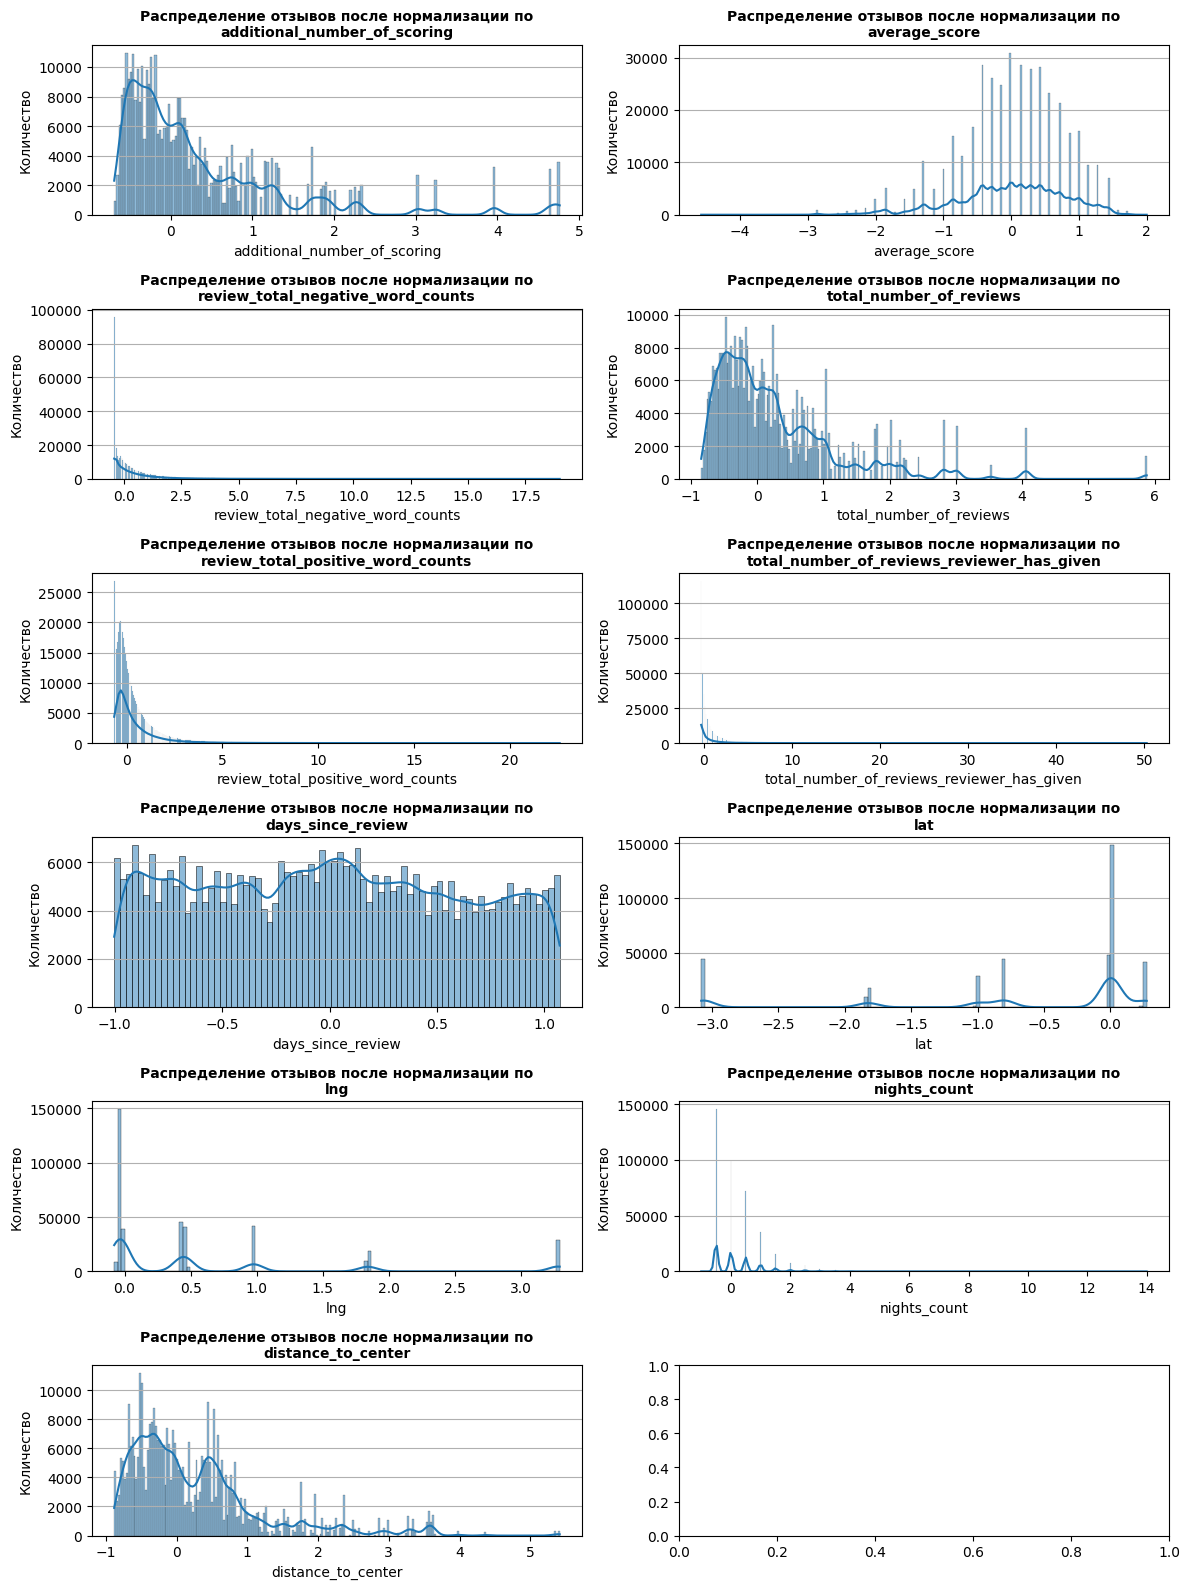

In [73]:
if to_scale_list:
    fig, axes = plt.subplots((len(to_scale_list)+1)//2, 2, figsize = (12,16))
    for i, col in enumerate(to_scale_list):
        ax= axes[i // 2, i % 2]
        
        sns.histplot(
            X[col],
            kde= True,
            ax= ax)
        
        # Украшательство
        
        title_text= "Распределение отзывов после нормализации"
        ax.set_title(f'{title_text} по\n{col}', fontweight= 'bold', fontsize= 10)
        ax.set_xlabel(col)
        ax.set_ylabel('Количество')
        ax.tick_params(axis='x')
        ax.grid(axis='y')

    plt.tight_layout();

    experiment.log_figure(figure= fig, figure_name= title_text+'.png')

### Проверим на коллинеарность

In [74]:
# Напишем функцию фильтрующую мультиколлинеарность
def multicorr(df, columns=None, multi = True):
    if columns == None:
        corr = df.corr(numeric_only = True, method='spearman')
    else: 
        corr = df.drop(columns=columns, axis=1).corr(numeric_only = True, method='spearman')
    
    if multi:
        # заполняем диагональ нулями
        np.fill_diagonal(corr.values, 0)

        # ставим маску с нужным коэффициентом
        mask= abs(corr)>0.7

        # Определяем список признаков, удовлетворяющих маске
        relevant_features = corr.index[mask.any(axis=1)].tolist()

        # фильтруем матрицу, используя метод `loc`
        corr = corr.loc[relevant_features, relevant_features]
        np.fill_diagonal(corr.values, 1)
    
    return corr

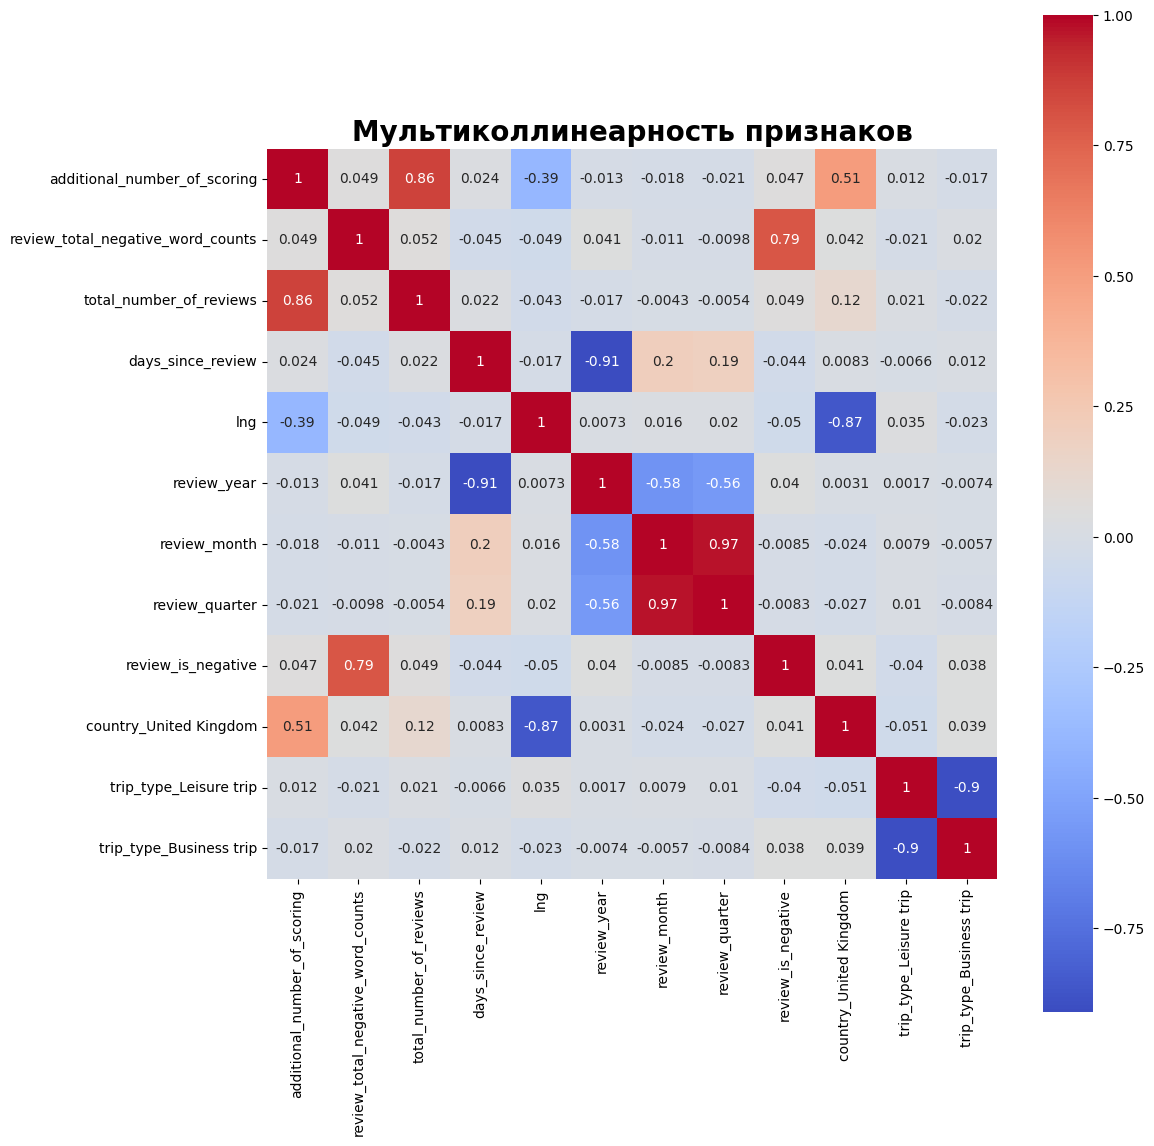

In [75]:
multi_check = multicorr(X, multi=True)
fig, ax = plt.subplots(figsize = (12,12))
    
heat_multicoll = sns.heatmap(multi_check, 
            square= True, 
            annot= True,
            cmap= 'coolwarm')

title_text = "Мультиколлинеарность признаков"
heat_multicoll.set_title(title_text, fontweight = 'bold', fontsize=20)

experiment.log_figure(figure= fig, figure_name= title_text+'.png')
plt.tight_layout()

In [76]:
# Опредлим список сильноскоррелированных признаков
corr_columns = ['additional_number_of_scoring', 'days_since_review', 'review_quarter', 'trip_type_Leisure trip']
X = X.drop(columns=corr_columns, axis=1) if corr_columns else X

experiment.log_asset_data("/n".join(corr_columns), name="Мультикоррениальные признаки.txt")

{'web': 'https://www.comet.com/api/asset/download?assetId=dc9e8dba08514892a695f7249bb4a988&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=dc9e8dba08514892a695f7249bb4a988&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'assetId': 'dc9e8dba08514892a695f7249bb4a988'}

In [77]:
# Скорректируем список числовых признаков
numeric_columns = [col for col in numeric_columns if col not in corr_columns]
cat_columns = [col for col in cat_columns if col not in corr_columns]

### Кси Квадрат

Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат, реализованный в библиотеке [sklearn.feature_selection.chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2). Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

{'web': 'https://www.comet.com/api/image/download?imageId=1833f20241574870be53496d005d19b4&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=1833f20241574870be53496d005d19b4&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': '1833f20241574870be53496d005d19b4'}

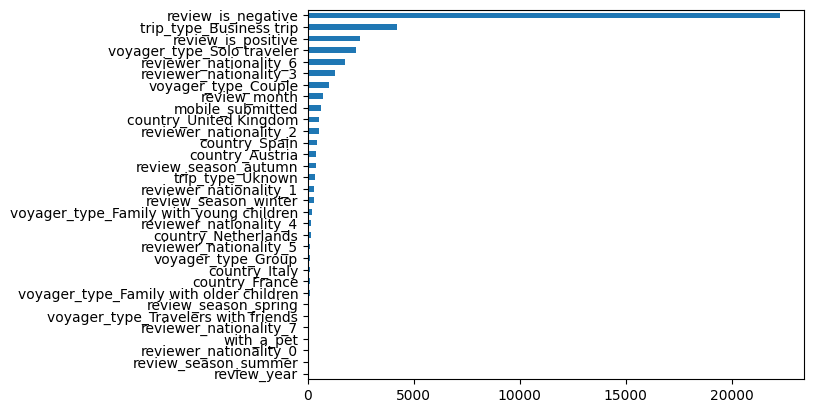

In [78]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_columns], y)[0], index=cat_columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

fig = plt.gcf()

experiment.log_figure(figure= fig, figure_name= "Значимость категориальных признаков.png")

In [79]:
from sklearn.feature_selection import SelectKBest
# Выберем K лучших признаков
k = 15
selector = SelectKBest(chi2, k=k)

# Обучаем селектор на категориальных признаках
X_selected = selector.fit_transform(X[cat_columns], y)

# Получаем маску (True/False) выбранных признаков
mask = selector.get_support()

# Имена выбранных столбцов
cat_columns_np = np.array(cat_columns)   # вариант 1
selected_cat_columns = cat_columns_np[mask]

print("Выбранные признаки:", selected_cat_columns)

# Можно также посмотреть на статистики и p-value для всех признаков
scores = pd.Series(selector.scores_, index=cat_columns)
pvalues = pd.Series(selector.pvalues_, index=cat_columns)

Выбранные признаки: ['review_month' 'review_is_negative' 'review_is_positive'
 'mobile_submitted' 'country_United Kingdom' 'country_Austria'
 'country_Spain' 'review_season_autumn' 'trip_type_Business trip'
 'trip_type_Uknown' 'voyager_type_Couple' 'voyager_type_Solo traveler'
 'reviewer_nationality_2' 'reviewer_nationality_3'
 'reviewer_nationality_6']


### ANOVA

Для оценки значимости непрерывных переменных будем использовать функцию [f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) из библиотеки `sklearn`. В основе метода оценки значимости переменных лежит анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

Метод возвращает двумерный массив f-статистик и p-value для каждого признака. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

{'web': 'https://www.comet.com/api/image/download?imageId=a64e2d077b824e6f9ec92f4f5ef98b9d&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=a64e2d077b824e6f9ec92f4f5ef98b9d&experimentKey=b65a10d9987e4d1c92ec8a400278376a',
 'imageId': 'a64e2d077b824e6f9ec92f4f5ef98b9d'}

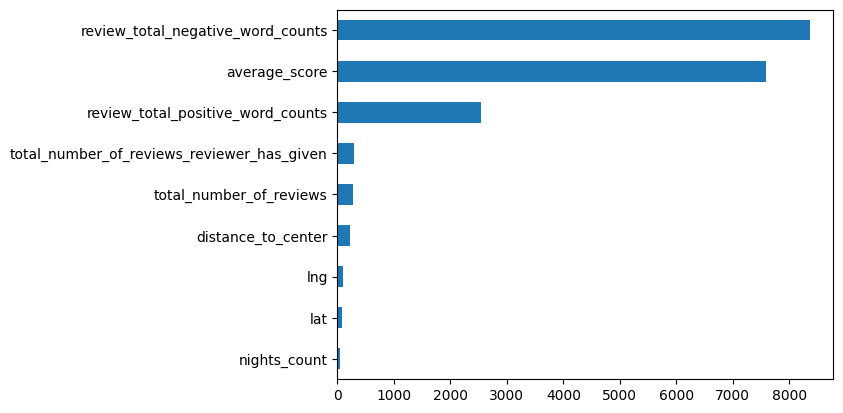

In [80]:
from sklearn.feature_selection import f_classif # anova
imp_num = pd.Series(f_classif(X[numeric_columns], y)[0], index = numeric_columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

fig = plt.gcf()

experiment.log_figure(figure= fig, figure_name= "Значимость числовых признаков.png")

In [81]:
selected_num_columns = ['review_total_positive_word_counts', 'average_score', 'review_total_negative_word_counts']

In [82]:
stat_list = selected_cat_columns.tolist()
stat_list.extend(selected_num_columns)

In [83]:
# Наилучший результат достигается, если не удаляем признаки. Поэтому обнуляем stat_list
stat_list = []

In [84]:
if stat_list:
    X = X[stat_list]

X.head()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,nights_count,distance_to_center,review_year,...,voyager_type_Family with older children,voyager_type_Travelers with friends,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,0.000000,-0.285714,-0.056634,-0.411765,0.571429,0.002396,-0.032813,0.0,-0.503494,2016,...,0,0,0,0,0,0,0,0,0,1
1,-0.142857,-0.285714,-0.312702,-0.529412,1.571429,0.006368,-0.028685,-0.5,-0.339508,2017,...,0,0,0,0,0,0,0,0,0,1
2,0.714286,-0.142857,-0.699029,-0.647059,1.571429,-0.803884,0.462582,0.5,-0.057794,2016,...,0,0,0,0,0,0,0,0,1,0
3,-1.285714,-0.428571,-0.617718,0.000000,0.714286,-0.790766,0.476404,-0.5,0.831761,2015,...,0,0,0,0,0,0,0,0,0,1
4,0.142857,-0.238095,2.205502,0.529412,1.000000,0.268189,0.968430,2.0,0.698874,2016,...,0,0,0,0,0,0,0,0,1,1


### Создание и обучение модели на выборке

In [85]:
def train_model(X, y, X_test= None, test_size = None, random_state = 42):
    regr = RandomForestRegressor(n_estimators= 100, verbose=1, n_jobs=-1, random_state=random_state)
    y_test= None
    if test_size!= None:        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
    else:
        X_train = X
        y_train = y
        regr.fit(X_train, y_train)
        y_pred= regr.predict(X_test)
    return  y_pred, y_test

In [86]:
y_pred, y_test = train_model(X, y, test_size= 0.25)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


### Оценка качества модели

MAPE: 0.15799675606516433


COMET INFO: Trying to log a figure that is exceeding allowed SVG file size limit (14166486 > 1048576). Falling back to PNG format.


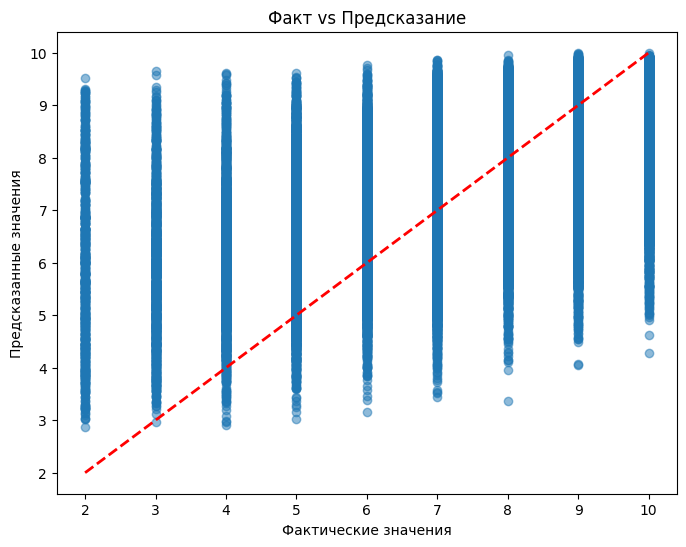

In [87]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', mape)

experiment.log_metric("MAPE", mape)

results_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
experiment.log_table("predictions_sample.csv", results_df.head(100))

# График "факт против предсказания"
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Факт vs Предсказание')
experiment.log_figure(figure=plt.gcf(), figure_name="actual_vs_predicted.png")
plt.show() 

# Обучение на полной выборке будем проводить после достижения приемлимого результата

## Обучение на полной выборке и предсказание submission

In [88]:
Z, c = data_separation(df_clean_hotel_test, False)
Z.shape

(128935, 45)

In [89]:
# Применим по порядку операции для тестовой выборки
if to_scale_list:
    Z = robust_scaler(Z, to_scale_list)
    
Z = Z.drop(columns=corr_columns, axis=1) if corr_columns else Z

if stat_list:
    Z = Z[stat_list]

In [90]:
y_pred, y_test = train_model(X, y, X_test=Z)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.4s finished


In [91]:
df_submission['reviewer_score'] = y_pred
df_submission.to_csv('data/new_submission.csv', index=False)
df_submission.head(10)

,reviewer_score,id
0,8.31,488440
1,7.26,274649
2,7.34,374688
3,9.34,404352
4,9.26,451596
5,7.77,302161
6,6.95,317079
7,7.05,13963
8,8.25,159785
9,7.62,195089


In [92]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ancient_embassy_2309
COMET INFO:     url                   : https://www.comet.com/deslum/booking-model/b65a10d9987e4d1c92ec8a400278376a
COMET INFO:   Metrics:
COMET INFO:     MAPE                       : 0.15799675606516433
COMET INFO:     categorical_features_count : 34
COMET INFO:     numeric_features_count     : 11
COMET INFO:   Parameters:
COMET INFO:     alpha                           : 0.05
COMET INFO:     k                               : 15
COMET INFO:     score_func                      : <function chi2 at 0x000001D014AC4B80>
COMET INFO:     unique_threshold                : 12
COMET INFO:     Очищено дубликатов:             : 307
COMET IN